# Comparison metrics

Because we cannot trust the human eyes to make comparison between pictures, especially if the eye is French and colorblind.

## Requirements

In [80]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))

import torch
import pyvips
import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

%pip install piq
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics import mutual_info_score
from skimage.color import rgb2lab
from skimage import io, color, filters
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance
import cv2
import seaborn as sns
from piq import multi_scale_ssim, gmsd


/home/leolr-int/miniforge3/envs/py312/lib/python3.12/site-packages/deeplake/__init__.py:322: UserWarning: Global variable 'KFBio_1' of type <class 'deeplake._deeplake.ReadOnlyDataset'> may cause issues when using fork-based multiprocessing. Consider avoiding global variables of this type, or pass to subprocess as an agrument or by manual pickling.
  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


Functions to migrate image appearance

In [68]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)
    

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def modif_FDA_source_to_target_np( src_img, amp_trg, L=0.1 ):
    fft_src_np = np.fft.fft2( src_img, axes=(-2, -1) )
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

def image_to_label(src_img, label, L_hyperparam=0.1):
    # computes the transformation of KBio images to the label-based amplitude
    trg_amp = np.load(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/label_based_average/average_label_{label}_akoya.npy")
    return modif_FDA_source_to_target_np( src_img, trg_amp, L=L_hyperparam)

Load_and_preprocess_image is used to load image anc create a grayscale version (useful for some metrics).

compute_similarity_metrics compute all the metrics needed for comparison.

comparison_plots displays several plots to show the difference between the source image and its transformed version (for example one coming the label-based average FDA). 

list_to_comp_plot reproduce the same plots but for several images

metrics_summary prints the metrics for each image and displays summary graphs to evaluate the most similar image

In [198]:
def load_and_preprocess_image(img_array):
    """Load image from numpy array and convert to appropriate format"""
    img = img_array.copy()

    # Convert to grayscale if needed for some metrics
    if len(img.shape) == 3:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # Normalize to [0, 1] range
    if img.max() > 1:
        img = img.astype(np.float64) / 255.0
        img_gray = img_gray.astype(np.float64) / 255.0

    return img, img_gray

def compute_similarity_metrics(original, comparison):
    original, original_gray = load_and_preprocess_image(original)
    comparison, comparison_gray = load_and_preprocess_image(comparison)
    """Compute various similarity metrics between two images"""
    metrics = {}
    

    # 1. Structural Similarity Index (SSIM)
    metrics['SSIM'] = ssim(original_gray, comparison_gray, data_range=1.0)
   
    # 2. Peak Signal-to-Noise Ratio (PSNR)
    metrics['PSNR'] = psnr(original, comparison, data_range=1.0)

    # 3. Root Mean Squared Error (RMSE) to show color deviations
    metrics['MSE'] = mse(original, comparison)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # 4. Normalized Cross-Correlation (NCC)
    original_flat = original_gray.flatten()
    comparison_flat = comparison_gray.flatten()
    correlation, _ = pearsonr(original_flat, comparison_flat)
    metrics['Correlation'] = correlation

    # 5. Cosine Similarity
    metrics['Cosine_Similarity'] = 1 - cosine(original_flat, comparison_flat)

    # 6. Earth Mover's Distance (for color images)
    if len(original.shape) == 3:
        original_uint8 = (original * 255).astype(np.uint8)
        comparison_uint8 = (comparison * 255).astype(np.uint8)

        # Flatten images to get pixel values
        orig_pixels = original_uint8.reshape(-1, 3)
        comp_pixels = comparison_uint8.reshape(-1, 3)
        
        # Option 1: Compare each color channel separately
        wasserstein_r = wasserstein_distance(orig_pixels[:, 0], comp_pixels[:, 0])
        wasserstein_g = wasserstein_distance(orig_pixels[:, 1], comp_pixels[:, 1])
        wasserstein_b = wasserstein_distance(orig_pixels[:, 2], comp_pixels[:, 2])
        
        # Average across channels
        metrics['EMD'] = (wasserstein_r + wasserstein_g + wasserstein_b) / 3
        
    
    # 7. Edge-based similarity using Sobel filters (applied on gray sclae)
    edges_orig = filters.sobel(original_gray)
    edges_comp = filters.sobel(comparison_gray)
    edge_similarity = ssim(edges_orig, edges_comp, data_range=edges_orig.max() - edges_orig.min())
    metrics['Edge_SSIM'] = edge_similarity

    # 8. Edge-based similarity using Gradient Magnitude Similarity Deviation (applied on colors)
    # computed across all channels and then it is averaged
    original = original.astype(np.float32)
    comparison = comparison.astype(np.float32)
    original = np.clip(original, 0.0, 1.0) #because some pixel are above 255
    comparison = np.clip(comparison, 0.0, 1.0)

    # Convert to PyTorch tensor with shape [1, 3, H, W] (adds batch size)
    original_tensor = torch.from_numpy(original).permute(2, 0, 1).unsqueeze(0)
    comparison_tensor = torch.from_numpy(comparison).permute(2, 0, 1).unsqueeze(0)

    # Compute GMSD per channel
    gmsd_values = []
    for c in range(3):
        gmsd_c = gmsd(original_tensor[:, c:c+1], comparison_tensor[:, c:c+1], data_range=1.0)
        gmsd_values.append(gmsd_c.item())

    metrics["GMSD"] = np.mean(gmsd_values)

    return metrics

def comparison_plots(original, comparison, original_gray, comparison_gray, title):
    """Create various difference visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle(f'Difference Analysis: {title} for L={L_hyperparam}', fontsize=16)

    # 1. Original image
    axes[0, 0].imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # 2. Comparison image
    axes[0, 1].imshow(comparison, cmap='gray' if len(comparison.shape) == 2 else None)
    axes[0, 1].set_title('Comparison Image')
    axes[0, 1].axis('off')

    # 3. Difference histogram
    diff_flat = (original_gray - comparison_gray).flatten()
    axes[0, 2].hist(diff_flat, bins=50, alpha=0.7, color='blue')
    axes[0, 2].set_title('Difference Histogram')
    axes[0, 2].set_xlabel('Pixel Difference')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Euclidian distance
    
    #sq_diff = np.linalg.norm(original - comparison, axis=-1) #first way to do it

    #this way is closer from human perception:
    original_lab = rgb2lab(original)
    comparison_lab = rgb2lab(comparison)
    sq_diff = np.linalg.norm(original_lab - comparison_lab, axis=-1)
    
    im2 = axes[1, 0].imshow(sq_diff, cmap='hot')
    axes[1, 0].set_title('Euclidian distance of colors')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0])

    # 5. Gradient magnitude
    def compute_gradient_magnitude(image):
        """
        Compute gradient magnitude for each channel of a [H, W, 3] image.
        Returns array of shape [3, H, W].
        """
        grad_mag = []
        for c in range(3):
            gx = filters.sobel(image[:, :, c], axis=1)
            gy = filters.sobel(image[:, :, c], axis=0)
            mag = np.sqrt(gx**2 + gy**2)
            grad_mag.append(mag)
        return np.stack(grad_mag)  # Shape: (3, H, W)

    # Assume original and comparison are [H, W, 3], in [0, 1]
    grad_orig = compute_gradient_magnitude(original)
    grad_comp = compute_gradient_magnitude(comparison)

    # Compute absolute difference and average over channels
    grad_diff_map = np.abs(grad_orig - grad_comp).mean(axis=0)  # Shape: (H, W)

    # Plot the gradient difference heatmap
    im_grad = axes[1, 1].imshow(grad_diff_map, cmap='inferno')
    axes[1, 1].set_title('Gradient Magnitude Difference (RGB avg)')
    axes[1, 1].axis('off')
    plt.colorbar(im_grad, ax=axes[1, 1])

    # SSIM map
    ssim_map = ssim(original_gray, comparison_gray, data_range=1.0, full=True)[1]
    im3 = axes[1, 2].imshow(ssim_map, cmap='RdYlBu')
    axes[1, 2].set_title('SSIM Map')
    axes[1, 2].axis('off')
    plt.colorbar(im3, ax=axes[1, 2])

    plt.tight_layout()
    return fig

def list_to_comp_plot(original, list_img, prints=True, save_results=True):
    """Main function to analyze image similarities"""

    # Load original image
    original, original_gray = load_and_preprocess_image(original)
    #print(f"Original image shape: {original.shape}")

    # Store all results
    all_metrics = {}

    # Compare each image with the original
    for i, comp_path in enumerate(list_img):
        #print(f"\nProcessing comparison image {i+1}")

        # Load comparison image
        comparison, comparison_gray = load_and_preprocess_image(comp_path)

        # Check if images have the same dimensions
        if original.shape != comparison.shape:
            print(f"Warning: Shape mismatch. Original: {original.shape}, Comparison: {comparison.shape}")
            # Resize comparison to match original
            if len(comparison.shape) == 3:
                comparison = cv2.resize(comparison, (original.shape[1], original.shape[0]))
            comparison_gray = cv2.resize(comparison_gray, (original.shape[1], original.shape[0]))

        # Compute metrics
        metrics = compute_similarity_metrics(original, comparison)
        all_metrics[f'label{i}'] = metrics

        # Create visualizations
        if prints:
            fig = comparison_plots(original, comparison, original_gray, comparison_gray, f'Label {i}')
            plt.show()

            if save_results:
                fig.savefig(f'/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/metrics_visualisation/comparison_image_{i+1}_L={L_hyperparam}.png', dpi=300, bbox_inches='tight')


    # Create summary comparison
    #create_summary_comparison(all_metrics, save_results)

    return all_metrics


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08506792052279027..1.3157285702778365].


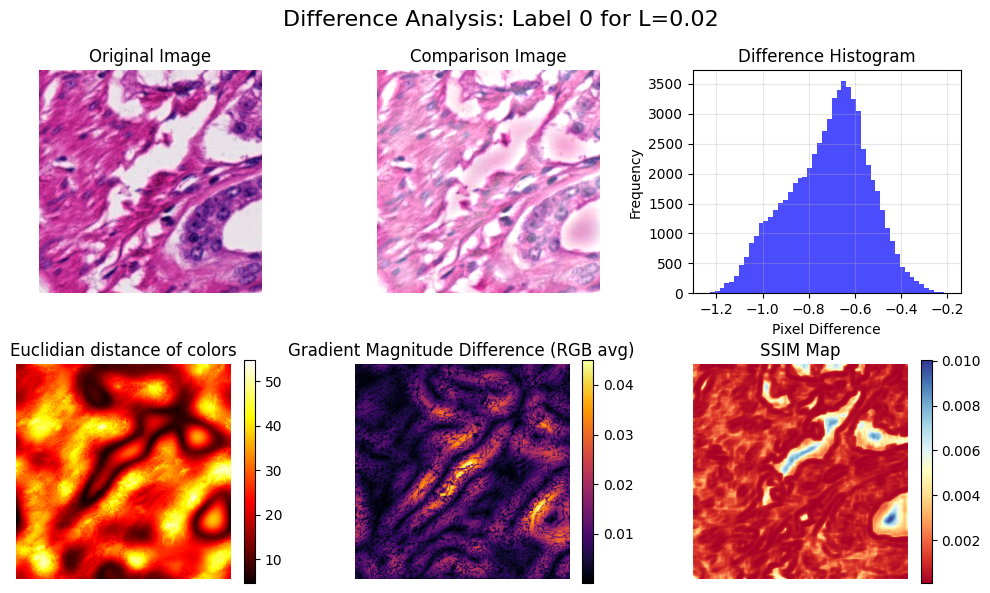

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12687278519357917..1.3399731550458727].


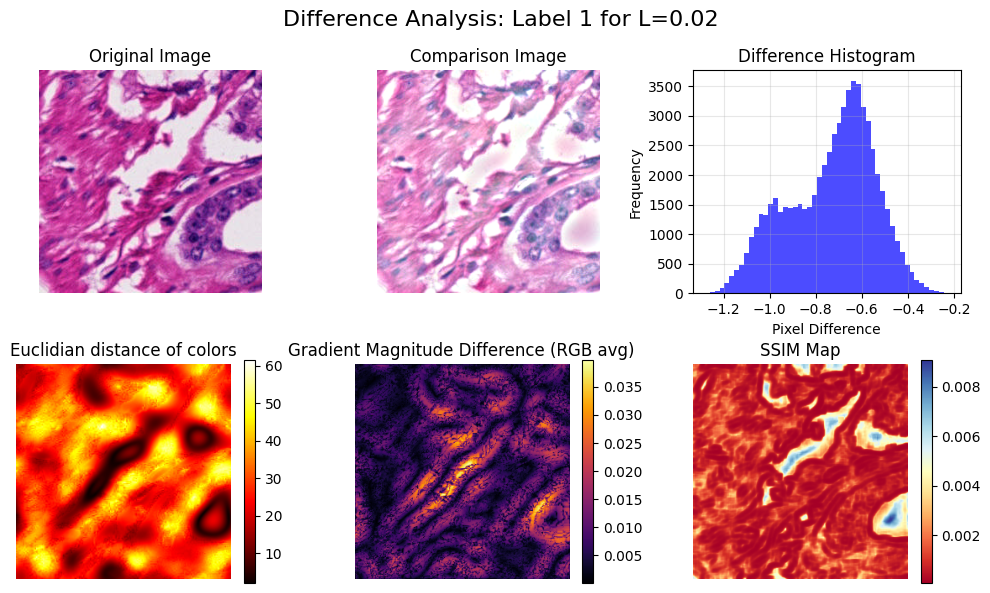

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11594202538902579..1.2939400061026878].


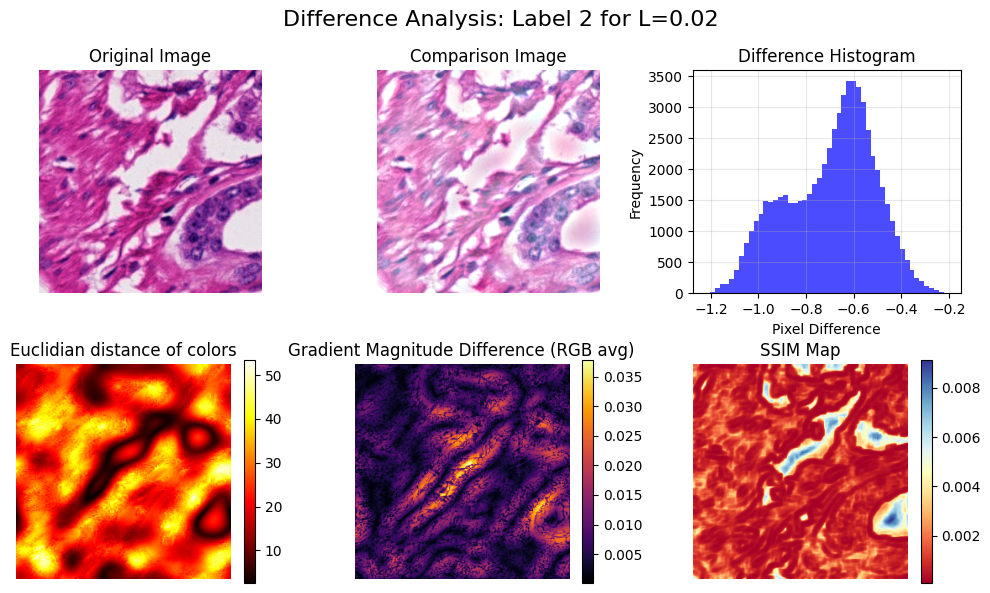

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1117776991572994..1.294110126557832].


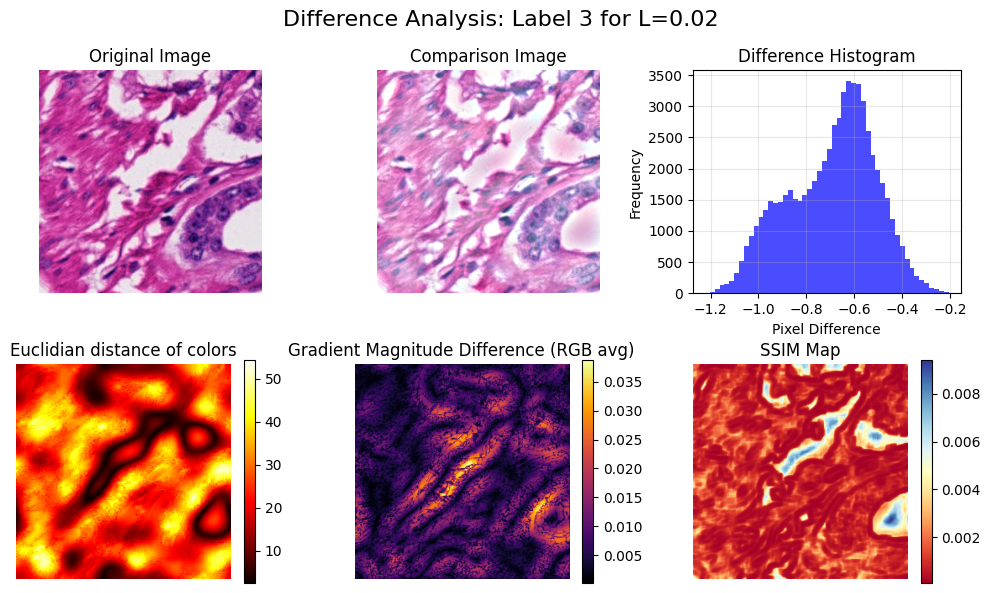

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01619596442367656..1.2268483836726867].


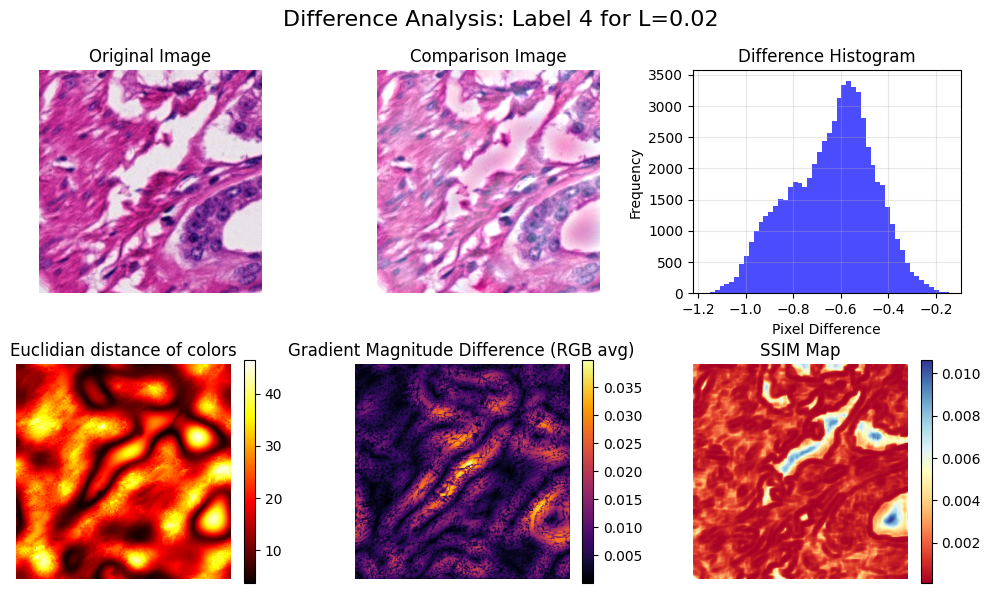

In [199]:
# Definining variables 
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)

L_hyperparam = 0.02 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
    
src_img = KFBio_1[1452]["patch"].transpose((2, 1, 0))
print(KFBio_1[1452]["label"]) #0
KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))
KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))
KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))
KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))
KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))

all_metrics = list_to_comp_plot(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], prints=True, save_results=True)

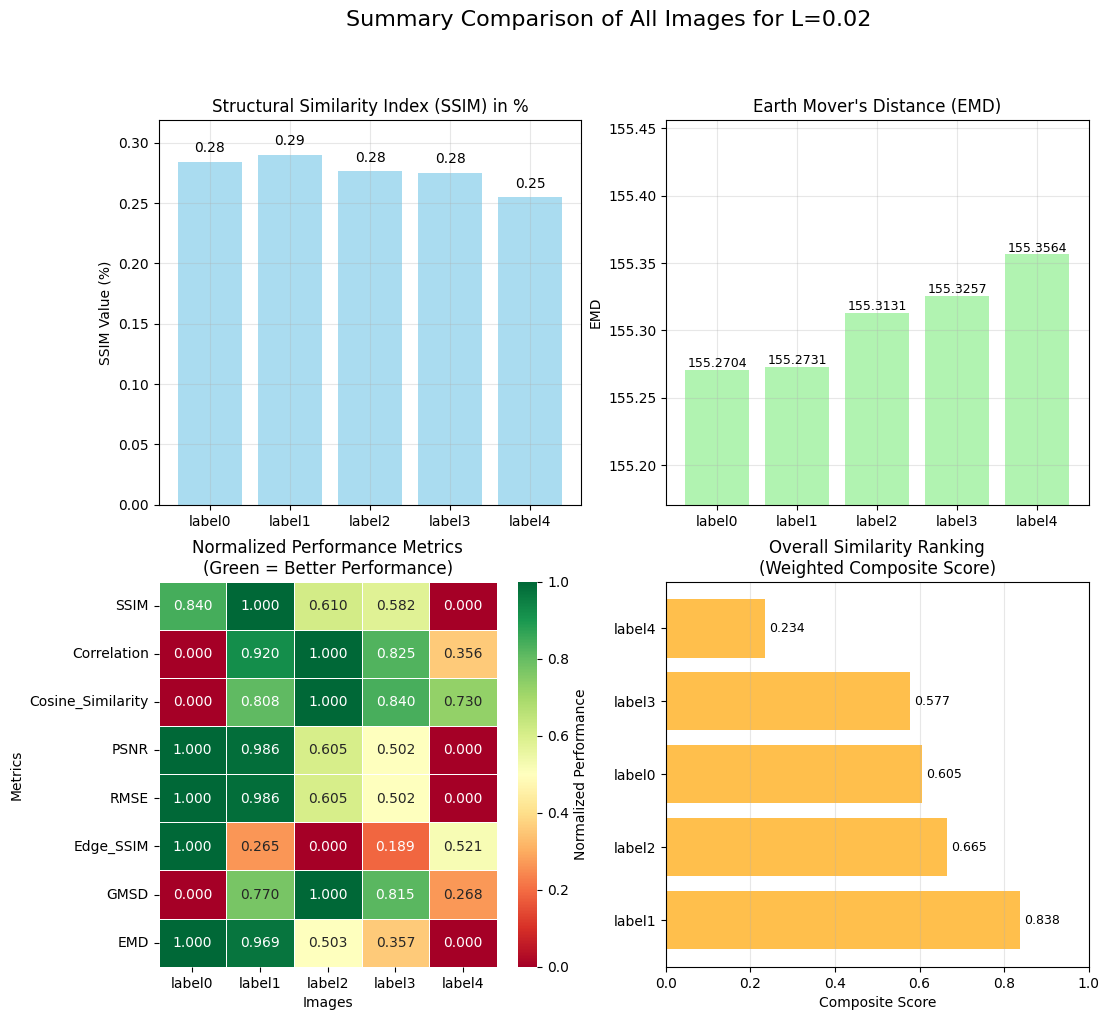


DETAILED SIMILARITY ANALYSIS RESULTS

label0:
--------------------------------------------------
Correlation:                      0.866663
Cosine Similarity:                0.966926
PSNR (Peak SNR):                  3.652532 dB
RMSE (Root Mean Squared Error):   0.656710
SSIM (Structural Similarity):     0.002844
Edge SSIM:                        0.020760
GMSD (Gradient Magnitude Sim Dev): 0.305358
Earth Mover's Distance:           155.270386
Composite Score:                  0.605039

label1:
--------------------------------------------------
Correlation:                      0.912741
Cosine Similarity:                0.973461
PSNR (Peak SNR):                  3.652492 dB
RMSE (Root Mean Squared Error):   0.656713
SSIM (Structural Similarity):     0.002900
Edge SSIM:                        0.020678
GMSD (Gradient Magnitude Sim Dev): 0.305304
Earth Mover's Distance:           155.273061
Composite Score:                  0.837898

label2:
-----------------------------------------------

,SSIM,PSNR,MSE,RMSE,Correlation,Cosine_Similarity,EMD,Edge_SSIM,GMSD
label0,0.002844,3.652532,0.431268,0.656710,0.866663,0.966926,155.270386,0.020760,0.305358
label1,0.002900,3.652492,0.431272,0.656713,0.912741,0.973461,155.273061,0.020678,0.305304
label2,0.002762,3.651398,0.431380,0.656795,0.916741,0.975019,155.313100,0.020648,0.305288
label3,0.002752,3.651103,0.431410,0.656818,0.907963,0.973721,155.325724,0.020669,0.305301
label4,0.002546,3.649660,0.431553,0.656927,0.884469,0.972836,155.356410,0.020706,0.305339


In [200]:
def metrics_summary(all_metrics, prints = True, save_results=True):
    """Create summary comparison of all metrics"""

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(all_metrics).T


    # Define metrics for comprehensive analysis
    metrics_for_analysis = ['SSIM', 'Correlation', 'Cosine_Similarity', 'PSNR', 'RMSE', 'Edge_SSIM', 'GMSD', 'EMD']
    df_analysis = df[metrics_for_analysis].copy()

    # Normalization function with consistent scaling
    def normalize_metric(series, higher_is_better=True):
        """Normalize metrics to 0-1 scale for fair comparison"""
        min_val = series.min()
        max_val = series.max()
        range_val = max_val - min_val
        
        if range_val == 0:
            return pd.Series(np.ones(len(series)), index=series.index)
        
        if higher_is_better:
            return (series - min_val) / range_val
        else:
            return (max_val - series) / range_val

    # Create normalized metrics DataFrame
    df_normalized = pd.DataFrame(index=df_analysis.index)
    
    # Define which metrics are better when higher
    higher_is_better_metrics = {
        "PSNR": True,
        "RMSE": False,
        "SSIM": True,
        "Edge_SSIM": True,
        "GMSD": False,
        "Correlation": True,
        "Cosine_Similarity": True,
        "EMD": False
    }
    
    # Normalize each metric appropriately
    for metric in metrics_for_analysis:
        df_normalized[metric] = normalize_metric(
            df_analysis[metric], 
            higher_is_better_metrics[metric]
        )


    # Calculate weighted composite score
    # Weights based on metric importance for image similarity assessment
    metric_weights = {
        "PSNR": 1/8,
        "RMSE": 1/8,
        "SSIM": 1/8,           # Most important structural metric
        "Edge_SSIM": 1/8,      # Edge preservation is important
        "GMSD": 1/8,
        "Correlation": 1/8,
        "Cosine_Similarity": 1/8,
        "EMD": 1/8
    }
    
    # Calculate composite score
    composite_scores = pd.Series(0.0, index=df_normalized.index)
    for metric, weight in metric_weights.items():
        composite_scores += weight * df_normalized[metric]

    # Sort by composite score (descending)
    sorted_scores = composite_scores.sort_values(ascending=False)



    
    # Create summary plots
    if prints:
        
        fig2, axes = plt.subplots(2, 2, figsize=(12, 11))
        fig2.suptitle(f'Summary Comparison of All Images for L={L_hyperparam}', fontsize=16, y=0.98)

        # SSIM comparison
        ssim_values = df['SSIM'].values * 100
        axes[0, 0].bar(df.index, ssim_values, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Structural Similarity Index (SSIM) in %')
        axes[0, 0].set_ylabel('SSIM Value (%)')
        axes[0, 0].set_ylim(0, max(ssim_values) * 1.1)
        axes[0, 0].grid(True, alpha=0.3)
        for i, v in enumerate(ssim_values):
            axes[0, 0].text(i, v + max(ssim_values) * 0.02, f'{v:.2f}', ha='center', va='bottom')

        # EMD comparison
        emd = df['EMD'].values
        bars = axes[0, 1].bar(df.index, emd, color='lightgreen', alpha=0.7)
        axes[0, 1].set_title("Earth Mover's Distance (EMD)")
        axes[0, 1].set_ylabel('EMD')
        axes[0, 1].set_ylim(min(emd) - 0.1 , max(emd) + 0.1 )
        axes[0, 1].grid(True, alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width() / 2., height, f'{height:.4f}', ha='center', va='bottom', fontsize=9)


        # Plot normalized metrics heatmap
        sns.heatmap(df_normalized.T, ax=axes[1, 0], annot=True, cmap="RdYlGn", 
                    cbar=True, fmt=".3f", linewidths=0.5, linecolor='white',
                    cbar_kws={'label': 'Normalized Performance'})
        
        axes[1, 0].set_title("Normalized Performance Metrics\n(Green = Better Performance)")
        axes[1, 0].set_xlabel("Images")
        axes[1, 0].set_ylabel("Metrics")
        
        # Create horizontal bar chart for ranking
        y_positions = range(len(sorted_scores))
        bars = axes[1, 1].barh(y_positions, sorted_scores.values, color='orange', alpha=0.7)
        axes[1, 1].set_yticks(y_positions)
        axes[1, 1].set_yticklabels(sorted_scores.index)
        axes[1, 1].set_title('Overall Similarity Ranking\n(Weighted Composite Score)')
        axes[1, 1].set_xlabel('Composite Score')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        axes[1, 1].set_xlim(0, 1.0)
        
        # Add score labels on bars
        for i, (bar, score) in enumerate(zip(bars, sorted_scores.values)):
            axes[1, 1].text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{score:.3f}', va='center', ha='left', fontsize=9)
            
        
        plt.show()

        # Print detailed results
        print("\n" + "="*80)
        print("DETAILED SIMILARITY ANALYSIS RESULTS")
        print("="*80)

        for img_name in df.index:
            metrics = all_metrics[img_name]
            print(f"\n{img_name}:")
            print("-" * 50)
            
            print(f"Correlation:                      {metrics['Correlation']:.6f}")
            print(f"Cosine Similarity:                {metrics['Cosine_Similarity']:.6f}")
            print(f"PSNR (Peak SNR):                  {metrics['PSNR']:.6f} dB")
            print(f"RMSE (Root Mean Squared Error):   {metrics['RMSE']:.6f}")
            print(f"SSIM (Structural Similarity):     {metrics['SSIM']:.6f}")
            print(f"Edge SSIM:                        {metrics['Edge_SSIM']:.6f}")
            print(f"GMSD (Gradient Magnitude Sim Dev): {metrics['GMSD']:.6f}")
            print(f"Earth Mover's Distance:           {metrics['EMD']:.6f}")
            print(f"Composite Score:                  {composite_scores[img_name]:.6f}")

        print(f"\nRANKING (Best to Worst Similarity):")
        print("-" * 50)
        for i, (img_name, score) in enumerate(sorted_scores.items(), 1):
            print(f"{i:2d}. {img_name:<20}: {score:.4f}")

        # Print weight information
        print(f"\nMETRIC WEIGHTS USED:")
        print("-" * 30)
        for metric, weight in metric_weights.items():
            print(f"{metric:<25}: {weight:.2f}")


        if save_results:
            fig2.savefig('/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/images/metrics_visualisation/summary_comparison.png', dpi=300, bbox_inches='tight')


    return df
metrics_summary(all_metrics, prints=True, save_results=True)

## What are the most relevant metrics for label match?

In [201]:
# Most discriminative metrics

df = pd.DataFrame(all_metrics).T

# Calculate the standard deviations
std_values = df.describe().loc['std']

# Sort the standard deviations in descending order and pick the top three
top_three_std = std_values.sort_values(ascending=False).head(3)

top_three_std

EMD                  0.036465
Correlation          0.021404
Cosine_Similarity    0.003158
Name: std, dtype: float64

In [202]:
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)

L_hyperparam = 0.02 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
    
src_img = KFBio_1[1452]["patch"].transpose((2, 1, 0))
print(KFBio_1[1452]["label"]) #0
KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))
KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))
KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))
KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))
KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))

all_metrics = list_to_comp_plot(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], prints=False, save_results=False)
metrics_summary(all_metrics, prints=False, save_results=False)

2


,SSIM,PSNR,MSE,RMSE,Correlation,Cosine_Similarity,EMD,Edge_SSIM,GMSD
label0,0.002844,3.652532,0.431268,0.656710,0.866663,0.966926,155.270386,0.020760,0.305358
label1,0.002900,3.652492,0.431272,0.656713,0.912741,0.973461,155.273061,0.020678,0.305304
label2,0.002762,3.651398,0.431380,0.656795,0.916741,0.975019,155.313100,0.020648,0.305288
label3,0.002752,3.651103,0.431410,0.656818,0.907963,0.973721,155.325724,0.020669,0.305301
label4,0.002546,3.649660,0.431553,0.656927,0.884469,0.972836,155.356410,0.020706,0.305339


In [214]:
# Choix heuristique du sens des métriques

results = []
label_metrics = []

for i in range(1, 2):  # 1 to 26
    dataset_path_KFBio = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_KFBio"
    if not os.path.exists(dataset_path_KFBio):
        print(f"Path not found: {dataset_path_KFBio}")
        continue

    KFBio = deeplake.open_read_only(dataset_path_KFBio)
    print(f"📂 Processing dataset {i} with {len(KFBio)} items...")

    for j in range(len(KFBio)//100):
        sample = KFBio[j]
        src_img = sample["patch"].transpose((2, 1, 0))
        true_label = int(sample["label"])

        if true_label != 3:
            continue

        try:
            # Générer les reconstructions
            predictions = [image_to_label(src_img, lbl, L_hyperparam=0.02).transpose((1, 2, 0)) for lbl in range(5)]
            all_metrics = list_to_comp_plot(src_img.transpose((1, 2, 0)), predictions, prints=False, save_results=False)

            # Résumé tabulaire
            df_metrics = metrics_summary(all_metrics, prints=False, save_results=False)
            df_metrics.index = [f"label{i}" for i in range(5)]

            # On ajoute à la liste uniquement les métriques du vrai label 3
            label_metrics.append(df_metrics)

        except Exception as e:
            print(f"⚠️ Error at index {j}: {e}")
            continue

    # ⚙️ Moyenne des métriques
    os.makedirs("label_metric_profiles", exist_ok=True)

    if label_metrics:
        df_all = pd.concat(label_metrics)  # concatène toutes les lignes
        df_mean = df_all.groupby(df_all.index).mean()  # moyenne par label reconstruit

        # Sauvegarde dans un CSV
        csv_path = "label_metric_profiles/label3_metric_profile.csv"
        df_mean.to_csv(csv_path)
        print(f"✅ Saved average metrics for true label 3 to {csv_path}")
    else:
        print("⚠️ Aucun exemple trouvé avec true_label == 3")

# Affichage des résultats
df_mean = pd.read_csv("label_metric_profiles/label3_metric_profile.csv", index_col=0)
print("\n📊 Average Metrics for True Label 3:")
print(df_mean)

📂 Processing dataset 1 with 11605 items...
✅ Saved average metrics for true label 3 to label_metric_profiles/label3_metric_profile.csv

📊 Average Metrics for True Label 3:
            SSIM      PSNR       MSE      RMSE  Correlation  \
label0  0.002891  3.988494  0.400793  0.632439     0.941533   
label1  0.002935  3.988240  0.400815  0.632457     0.935074   
label2  0.002797  3.987138  0.400917  0.632537     0.952783   
label3  0.002790  3.986843  0.400944  0.632559     0.953271   
label4  0.002586  3.985458  0.401072  0.632660     0.951807   

        Cosine_Similarity         EMD  Edge_SSIM      GMSD  
label0           0.986394  150.914038   0.003285  0.257919  
label1           0.988045  150.931926   0.003280  0.257900  
label2           0.989604  150.959693   0.003281  0.257901  
label3           0.989256  150.970565   0.003282  0.257905  
label4           0.989840  150.987409   0.003282  0.257929  


## Tests to check if Label-based Global FDA works

Be careful: there might be a difference between closest amplitude and metrics

In [217]:
import os
import pandas as pd
import deeplake
from multiprocessing import Pool, cpu_count
from functools import partial

def process_label(target_label, sample_step=100):
    """Process a specific label across all datasets"""
    label_metrics = []
    
    for i in range(1,2):
        dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_KFBio"
        print("processing dataset:", i)
            
        try:
            KFBio = deeplake.open_read_only(dataset_path)
            
            # Vectorized filtering - plus rapide
            labels = [int(KFBio[j]["label"]) for j in range(0, len(KFBio), sample_step)]
            indices = [j for j, lbl in enumerate(labels) if lbl == target_label]
            
            for idx in indices:
                sample = KFBio[idx * sample_step]
                src_img = sample["patch"].transpose((2, 1, 0))
                
                # Batch processing des predictions
                predictions = [image_to_label(src_img, lbl, L_hyperparam=0.02).transpose((1, 2, 0)) 
                              for lbl in range(5)]
                
                all_metrics = list_to_comp_plot(src_img.transpose((1, 2, 0)), predictions, 
                                              prints=False, save_results=False)
                df_metrics = metrics_summary(all_metrics, prints=False, save_results=False)
                df_metrics.index = [f"label{i}" for i in range(5)]
                label_metrics.append(df_metrics)
                
        except Exception as e:
            print(f"Error processing dataset {i} for label {target_label}: {e}")
            continue
    
    # Calcul des métriques moyennes
    if label_metrics:
        df_all = pd.concat(label_metrics, ignore_index=False)
        df_mean = df_all.groupby(df_all.index).mean()
        
        # Sauvegarde
        os.makedirs("label_metric_profiles", exist_ok=True)
        csv_path = f"label_metric_profiles/label{target_label}_metric_profile.csv"
        df_mean.to_csv(csv_path)
        print(f"✅ Label {target_label}: {len(label_metrics)} samples processed")
        return df_mean
    
    return None

def main():
    """Main function with multiprocessing"""
    labels_to_process = list(range(5))  # Labels 0 to 4
    
    # Utiliser tous les CPU disponibles sauf 1
    n_processes = min(len(labels_to_process), cpu_count() - 1)
    
    with Pool(n_processes) as pool:
        results = pool.map(process_label, labels_to_process)
    
    # Affichage des résultats
    for i, result in enumerate(results):
        if result is not None:
            print(f"\n📊 Label {i} - Average Metrics:")
            print(result.round(4))

if __name__ == "__main__":
    main()

processing dataset:processing dataset:processing dataset:processing dataset:    111
1


processing dataset: 1


KeyboardInterrupt: 

In [204]:
# Definining variables 
'''dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)

L_hyperparam = 0.05 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
    
src_img = KFBio_1[200]["patch"].transpose((2, 1, 0))
KFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))
KFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))
KFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))
KFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))
KFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))

all_metrics = list_to_comp_plot(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], prints=True, save_results=True)'''

'dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"\nKFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)\n\nL_hyperparam = 0.05 #float(input("Enter the L hyperparameter (e.g., 0.1): "))\n\nsrc_img = KFBio_1[200]["patch"].transpose((2, 1, 0))\nKFBio_to_0 = image_to_label(src_img, 0, L_hyperparam).transpose((1, 2, 0))\nKFBio_to_1 = image_to_label(src_img, 1, L_hyperparam).transpose((1, 2, 0))\nKFBio_to_2 = image_to_label(src_img, 2, L_hyperparam).transpose((1, 2, 0))\nKFBio_to_3 = image_to_label(src_img, 3, L_hyperparam).transpose((1, 2, 0))\nKFBio_to_4 = image_to_label(src_img, 4, L_hyperparam).transpose((1, 2, 0))\n\nall_metrics = list_to_comp_plot(src_img.transpose((1,2,0)), [KFBio_to_0, KFBio_to_1, KFBio_to_2, KFBio_to_3, KFBio_to_4], prints=True, save_results=True)'